# Project for Cognitive Modelling

We want to reconstruct the z-values given only the rgb-values (grayscale in this case) and a lightsource

In [1]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import numpy as np
import scipy.optimize as opt

## Define surface

In [2]:
grid_size = (10,10)

xx, yy = np.meshgrid(np.linspace(-2,2,grid_size[0]),np.linspace(-2,2,grid_size[1]))
zz = np.zeros(grid_size) 
inner = -xx**2 - yy**2 + 1
zz_s = np.sqrt(inner[inner>=0]) 
zz[inner>=0] = zz_s

## Add lightsource

In [3]:
greyscale = np.ones((grid_size[0],grid_size[1],3))
grey = 0.7
color = greyscale*grey

start_azimuth = 0
start_elevation = 0

light = LightSource(start_azimuth,start_elevation) # azimuth (rotation), elevation
illuminated_surface = light.shade_rgb(color,zz)
illumination = illuminated_surface[:,:,0]

## Plot figure

<IPython.core.display.Javascript object>


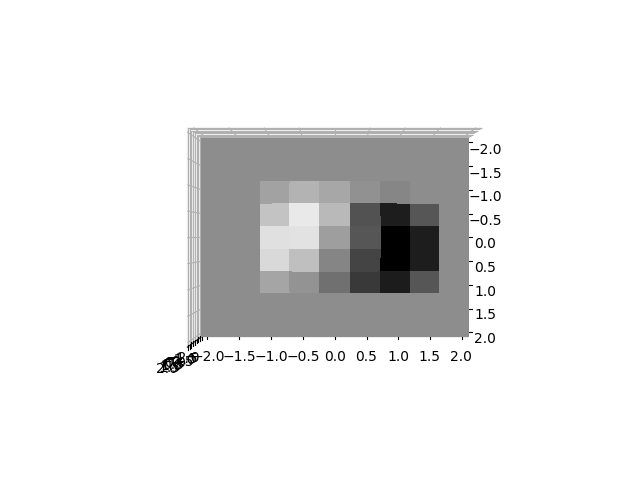

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

In [5]:
def ml_loss(zz_guess):
    zz_guess = np.reshape(zz_guess,grid_size)
    il_s = light.shade_rgb(color,zz_guess)
    il_guess = il_s[:,:,0]
    r = (il_guess-illumination).ravel()
    return np.log(r.dot(r))

def ml_loss_multi_light(zz_guess,lights):
    zz_guess = np.reshape(zz_guess,grid_size)
    loss = 0
    for l in lights:
        il_s = l.shade_rgb(color,zz_guess)
        il_guess = il_s[:,:,0]
        r = (il_guess-illumination).ravel()
        loss += r.dot(r)
    return np.log(loss/len(lights))

## ML estimation

In [6]:
init_guess = np.random.randn(*grid_size)
res = opt.fmin_bfgs(ml_loss,init_guess.ravel(),maxiter=10000)

zz_guess = np.reshape(res,grid_size)
illuminated_surface_guess = light.shade_rgb(color,zz_guess)

         Current function value: -18.424892
         Iterations: 334
         Function evaluations: 43156
         Gradient evaluations: 423


## 2D plot of reconstruction and original

<IPython.core.display.Javascript object>


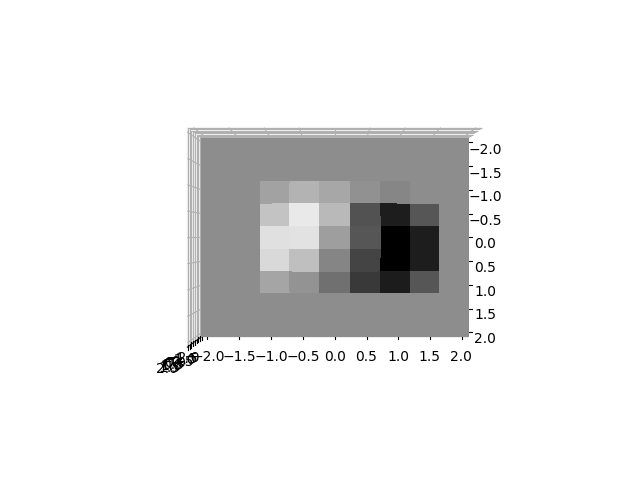

<IPython.core.display.Javascript object>


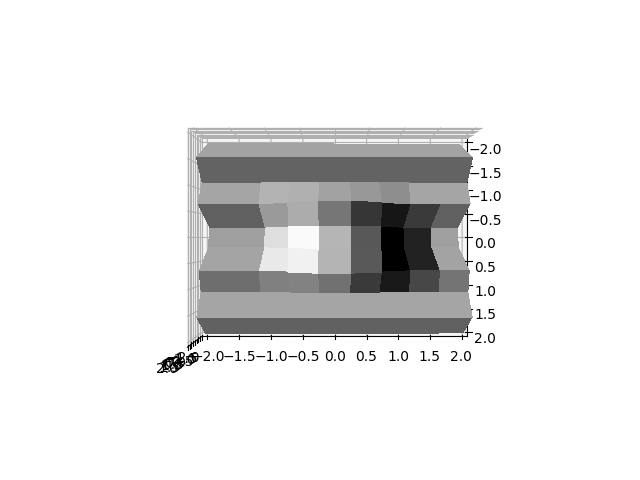

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz_guess,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface_guess)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

## 3D plot of reconstruction

<IPython.core.display.Javascript object>


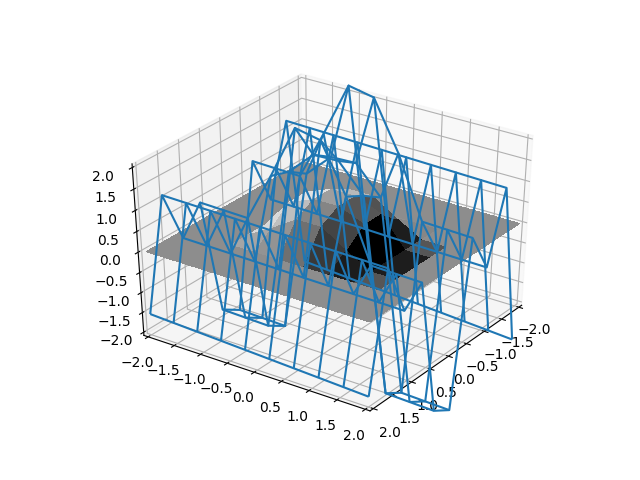

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.plot_wireframe(xx,yy,zz_guess,rstride=1,cstride=1)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(35,35) # elevation, azimuth (rotation)

## ML with multiple light sources

In [9]:
angles = 2*np.random.randn(5,)
lights = []
lights.append(light)
for angle in angles:
    lights.append(LightSource(start_azimuth+angle,start_elevation)) # azimuth (rotation), elevation

init_guess = np.random.randn(*grid_size)
res = opt.fmin_bfgs(ml_loss_multi_light,init_guess.ravel(),args=(lights,),maxiter=10000)

zz_guess = np.reshape(res,grid_size)
illuminated_surface_guess = light.shade_rgb(color,zz_guess)

         Current function value: -6.339965
         Iterations: 363
         Function evaluations: 43056
         Gradient evaluations: 422


## 2D plot of reconstruction and original

<IPython.core.display.Javascript object>


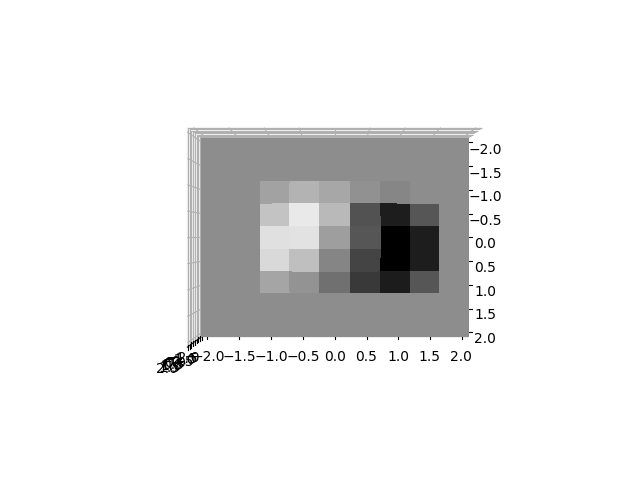

<IPython.core.display.Javascript object>


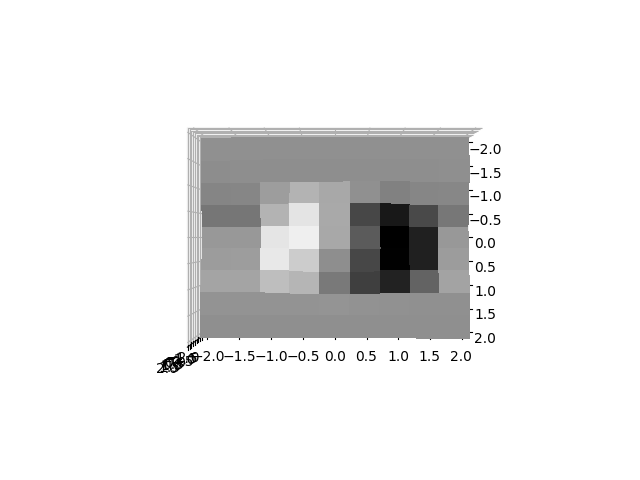

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz_guess,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface_guess)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

## 3D plot of reconstruction

<IPython.core.display.Javascript object>


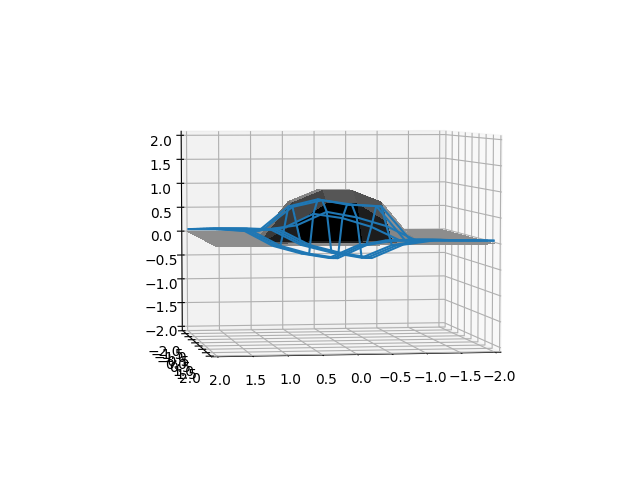

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.plot_wireframe(xx,yy,zz_guess,rstride=1, cstride=1)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(35,35) # elevation, azimuth (rotation)